In [1]:
from gurobipy import *
import numpy as np
#set seed
np.random.seed(123)

### PART 1: BASELINE MODEL

In [2]:
#BASELINE MODEL

cost = np.array([[1.5, 2.5, 4.5, 0, 12],
                [2, 2.6, 5.5, 6, 15], 
                [1, 0, 5, 7, 10],
                [1.2, 2, 7, 8, 13],
                [1.3, 2.2, 0, 10, 14]])

#supply and demand
supply = np.array([[100, 125, 200, 0, 25],
                [120, 140, 150, 10, 50], 
                [90, 0, 125, 50, 30],
                [75, 80, 110, 80, 80],
                [150, 125, 0, 110, 30]])

demand = np.array([[190, 100, 90, 25, 15],
                [30, 120, 100, 30, 50], 
                [80, 50, 90, 5, 50],
                [50, 160, 150, 20, 5],
                [70, 40, 20, 150, 30]])
supply = supply * 2

#asssuming common warehouse
demand2 = demand.sum(axis=0) #total demand for each type of fish

#cost from supplier to warehouse
truckdel = np.array([40, 80, 50, 70, 65])

#supply nodes: M, fish types: N
M, N = cost.shape

ARCS1 = tuplelist([(0,0), (0,1), (0,2), (0,3), (0,4),
                  (1,0), (1,1), (1,2), (1,3), (1,4),
                  (2,0), (2,1), (2,2), (2,3), (2,4),
                  (3,0), (3,1), (3,2), (3,3), (3,4),
                  (4,0), (4,1), (4,2), (4,3), (4,4)])

In [27]:
demand2

array([388., 427., 536., 241., 143.])

In [ ]:
n = 5  # numbre of restaurants franchise

B = [i for i in range(1, n+1)]

V = [0] + N

In [6]:
#model
def model_setup():
    
    fish = Model("Fish Warehouse")

    #variables
    x = fish.addVars(ARCS1, name = "Order")
    y = fish.addVars(M, name = "Trucks", vtype = GRB.INTEGER)

    #objective
    fish.setObjective(quicksum(cost[i,j]*x[i,j] for (i,j) in ARCS1) + 
                      quicksum(truckdel[i]*y[i] for i in range(M)), GRB.MINIMIZE)

    #constraints
    fish.addConstrs((x[i,j] <= supply[i,j] for (i,j) in ARCS1), "Supply")
    fish.addConstrs((quicksum(x[i,j] for (i,j) in ARCS1.select('*',j)) >= demand2[j] for j in range(N)), "Demand")
    fish.addConstrs((quicksum(x[i,j] for (i,j) in ARCS1.select(i,'*')) <= 500*y[i] for i in range(M)), "Trucks")

    fish.setParam( 'OutputFlag', False )
    
    return fish

#########Model Set-up############
#Minimize Travelling Cost
vr = Model("vehicle_routing")

# Create variables
X = vr.addVars(A, vtype=GRB.BINARY, name = "location")

u = vr.addVars(V,vtype=GRB.CONTINUOUS, name = "loc_count") #location of restaurants

# Set objective - minimize travelling costs
vr.setObjective( quicksum(c[i,j]*X[i,j] for (i,j) in A), GRB.MINIMIZE)

# Assignment constraints:
vr.addConstrs((quicksum(X[i,j] for j in V if j!=i) == 1 for i in N)) # outflow nodes
vr.addConstrs((quicksum(X[i,j] for i in V if i!=j) == 1 for j in N)) # inflow nodes

# Location count (nodes) constraints:
vr.addConstrs(( X[i, j] == 1) >> (u[i]+ F[j] == u[j])  for i, j in A if i != 0 and j != 0)

# Precedence constraints
vr.addConstrs(u[i] >= F[i] for i in N )

# Truck delivery capacity constraint:
vr.addConstrs(u[i] <= Q for i in N)

# Solving the model
vr.optimize()

In [8]:
#solving
fish = model_setup()

fish.optimize()

#optimals
i = 0
sol = []

print("\n Optimal solution:")
for v in fish.getVars():
    sol.append(v.x)
    i += 1
    if i % 5 == 0:
        if i / 5 < 6:
            print("Supplier " + str(i/5))
        else:
            print("\n Trucks")
        print(sol)
        sol = [] # create a new empty list
        
print("\n Minimal cost:", fish.objVal)


 Optimal solution:
Supplier 1.0
[0.0, 60.0, 390.0, 0.0, 50.0]
Supplier 2.0
[0.0, 0.0, 0.0, 0.0, 0.0]
Supplier 3.0
[180.0, 0.0, 60.0, 100.0, 60.0]
Supplier 4.0
[150.0, 160.0, 0.0, 130.0, 40.0]
Supplier 5.0
[90.0, 250.0, 0.0, 0.0, 0.0]

 Trucks
[1.0, 0.0, 1.0, 1.0, 1.0]

 Minimal cost: 7237.0


### PART 2: DEMAND UNCERTAINTY MODEL

In [9]:
#DEMAND UNCERTAINTY MODEL
mean = np.array([[190, 100, 90, 25, 15],
                [30, 120, 100, 30, 50], 
                [80, 50, 90, 5, 50],
                [50, 160, 150, 20, 5],
                [70, 40, 20, 150, 30]])

stdev = np.array([[30, 15, 20, 5, 8], 
                [20, 50, 30, 12, 8],
                [15, 15, 12, 2, 5],
                [8, 45, 30, 5, 3],
                [15, 10, 3, 35, 8]])

In [10]:
#uncertainty
Sample_Size = 1000
allsol = []
cost_full = np.zeros(Sample_Size)
alltrucks = []

for k in range(Sample_Size):
    udemand = np.zeros(shape = (M, N)) # demand matrix generated from the random variable normal distribution

    for i in range(M):
        for j in range(N):
            meanval = mean[i][j]
            stdevval = stdev[i][j]
            demand = np.ceil(np.maximum(np.random.normal(meanval, stdevval), 0))
            udemand[i][j] = demand
    
    #asssuming common warehouse
    demand2 = udemand.sum(axis=0) #total demand for each type of fish 
    
    #solving
    fish = model_setup()

    fish.optimize()

    #optimals
    count = 0
    i, j = 0, 0
    sol = np.zeros(shape = (M+1, N))

    for v in fish.getVars():
        sol[i, j] = v.x
        count += 1
        j += 1
        if count % 5 == 0:
            j = 0
            i += 1 

    trucks = sol[5] #6th row
    sol = sol[:-1]  #all rows except for last row
    
    alltrucks.append(trucks)
    allsol.append(sol)
    cost_full[k] = fish.objVal

In [11]:
finalsol = np.ceil((np.array(allsol)).mean(axis = 0))
finaltrucks = np.ceil((np.array(alltrucks)).mean(axis = 0))

print("\n Optimal solution:")
for i in range(len(finalsol)):
    print("Supplier " + str(i+1))
    print(finalsol[i].tolist())

print("\n Trucks:", finaltrucks.tolist())
    
print("\n Minimal cost:", np.average(cost_full))


 Optimal solution:
Supplier 1
[1.0, 65.0, 385.0, 0.0, 50.0]
Supplier 2
[0.0, 9.0, 0.0, 3.0, 0.0]
Supplier 3
[180.0, 0.0, 67.0, 100.0, 60.0]
Supplier 4
[145.0, 160.0, 0.0, 128.0, 44.0]
Supplier 5
[99.0, 244.0, 0.0, 4.0, 0.0]

 Trucks: [2.0, 1.0, 1.0, 1.0, 1.0]

 Minimal cost: 7350.732599999999


### PART 3: PROCUREMENT MODEL + CAPACITATED VEHICLE ROUTING PROBLEM

#### SCENARIO 1: ONE TRUCK WITH LIMITED CAPACITY + NO SUBTOUR CONSTRAINTS

**Assumptions**:
*  Truck Limited Holding Capacity
*  No subtour constrains - aka allow the truck to go back to pick up more fishes & continue the delivery
*  Only need to go to each restaurant once to deliver

<font color='darkcyan'>**I. Minimize total travelling costs LP**</font>

In [12]:
import matplotlib.pyplot as plt

In [13]:
rnd = np.random
rnd.seed(123)

In [14]:
n = 5  # numbre of restaurants franchise
#Randomize locations of warehouse and 5 restaurants on a 100X200 axis
xc = rnd.rand(n+1)*200   #n+1 means include the common warehouse
yc = rnd.rand(n+1)*100

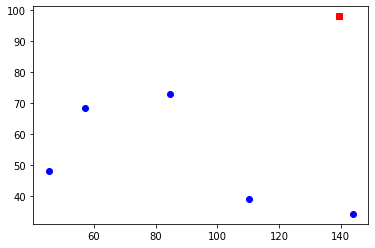

In [15]:
#Plot the random locations on axis
plt.plot(xc[0], yc[0], c='r', marker='s') #location of common warehouse
plt.scatter(xc[1:], yc[1:], c='b') #location of of 5 restaurants

In [16]:
# Set of restaurants
N = [i for i in range(1, n+1)]
N

[1, 2, 3, 4, 5]

In [17]:
#Set of nodes (including the common warehouse)
V = [0] + N
V

[0, 1, 2, 3, 4, 5]

In [18]:
#Set of Arcs from common warehouse to restaurants
A = [(i, j) for i in V for j in V if i != j]
A[1]

(0, 2)

In [19]:
i = 0
Arcs = []
node = []
for a in A:
    node.append(tuple(a))
    i += 1
    if i % 5 == 0:
        Arcs.append(node)
        node = [] # create a new empty list
Arcs

[[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)],
 [(1, 0), (1, 2), (1, 3), (1, 4), (1, 5)],
 [(2, 0), (2, 1), (2, 3), (2, 4), (2, 5)],
 [(3, 0), (3, 1), (3, 2), (3, 4), (3, 5)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 5)],
 [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4)]]

In [20]:
#traveling cost from node i to node j
c = np.array([[0, 51, 60, 42, 80, 66],
                 [51, 0, 27, 35, 42, 32],
                 [60, 27, 0, 40, 19, 25],
                 [42, 35, 40, 0, 64, 22],
                 [80, 42, 19, 64, 0, 57],
                 [66, 32, 25, 22, 57, 0]]
               )

In [21]:
#traveling distance from node i to node j (calculate the hypotenuse)
d = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
d

{(0, 1): 87.2387270555062,
 (0, 2): 106.39528100373309,
 (0, 3): 65.63414756317488,
 (0, 4): 63.92433809325889,
 (0, 5): 60.188778330570976,
 (1, 0): 87.2387270555062,
 (1, 2): 23.586975111554317,
 (1, 3): 60.57660335769294,
 (1, 4): 93.15708181065405,
 (1, 5): 27.74804121995107,
 (2, 0): 106.39528100373309,
 (2, 1): 23.586975111554317,
 (2, 3): 65.49761576948731,
 (2, 4): 99.48186779895522,
 (2, 5): 46.435606597129656,
 (3, 0): 65.63414756317488,
 (3, 1): 60.57660335769294,
 (3, 2): 65.49761576948731,
 (3, 4): 33.98505785136493,
 (3, 5): 42.340616676686906,
 (4, 0): 63.92433809325889,
 (4, 1): 93.15708181065405,
 (4, 2): 99.48186779895522,
 (4, 3): 33.98505785136493,
 (4, 5): 70.72622643868793,
 (5, 0): 60.188778330570976,
 (5, 1): 27.74804121995107,
 (5, 2): 46.435606597129656,
 (5, 3): 42.340616676686906,
 (5, 4): 70.72622643868793}

In [22]:
#Get the number of fishes purchased in part 2 (these will be delivered to restaurants)
finalsol.tolist()

[[1.0, 65.0, 385.0, 0.0, 50.0],
 [0.0, 9.0, 0.0, 3.0, 0.0],
 [180.0, 0.0, 67.0, 100.0, 60.0],
 [145.0, 160.0, 0.0, 128.0, 44.0],
 [99.0, 244.0, 0.0, 4.0, 0.0]]

In [52]:
#Total demand from all types of fishes for each restaurant (quantities that will be delivered)
demand4 = np.array(finalsol).sum(axis=1).tolist()
demand4

print(udemand)

[[130.  90.  95.  26.  15.]
 [ 36.  54. 132.  56.  39.]
 [101.  40. 120.   3.  49.]
 [ 60. 193. 167.  16.   2.]
 [ 61.  50.  22. 140.  38.]]


In [24]:
F = {1: 885.0, 2: 39.0, 3: 391.0, 4: 333.0, 5: 95.0}
F

{1: 885.0, 2: 39.0, 3: 391.0, 4: 333.0, 5: 95.0}

In [46]:
# Assume maximum capacity is the maximum purchased number fishes from the supplier otherwise model is infeasible
Q = 900

In [47]:
#########Model Set-up############
#Minimize Travelling Cost
vr = Model("vehicle_routing")

# Create variables
x = vr.addVars(A, vtype=GRB.BINARY, name = "location")

u = vr.addVars(V,vtype=GRB.CONTINUOUS, name = "loc_count") #location of restaurants

# Set objective - minimize travelling costs
vr.setObjective( quicksum(c[i,j]*x[i,j] for (i,j) in A), GRB.MINIMIZE)

# Assignment constraints:
vr.addConstrs((quicksum(x[i,j] for j in V if j!=i) == 1 for i in N)) # outflow nodes
vr.addConstrs((quicksum(x[i,j] for i in V if i!=j) == 1 for j in N)) # inflow nodes

# Location count (nodes) constraints:
vr.addConstrs(( x[i, j] == 1) >> (u[i]+ F[j] == u[j])  for i, j in A if i != 0 and j != 0)

# Precedence constraints
vr.addConstrs(u[i] >= F[i] for i in N )

# Truck delivery capacity constraint:
vr.addConstrs(u[i] <= Q for i in N)

# Solving the model
vr.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 20 rows, 36 columns and 60 nonzeros
Model fingerprint: 0x9e56ee93
Model has 20 general constraints
Variable types: 6 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 0 rows and 20 columns
Presolve time: 0.00s
Presolved: 20 rows, 16 columns, 72 nonzeros
Variable types: 4 continuous, 12 integer (12 binary)
Found heuristic solution: objective 302.0000000

Root relaxation: objective 2.320000e+02, 14 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  232.00000    0    8  302.00000  232.00000  23.2%     -    0s
H    0     0                   

In [48]:
print('Minimized delivery cost: %g' % vr.objVal)

Minimized delivery cost: 290


In [49]:
active_arcs = [a for a in A if x[a].x > 0.99]
active_arcs

[(0, 1), (0, 3), (1, 0), (2, 4), (3, 5), (4, 0), (5, 2)]

In [38]:
#print loc count
for v in u: 
    print(u[v].VarName, u[v].x)

loc_count[0] 0.0
loc_count[1] 885.0
loc_count[2] 372.0
loc_count[3] 858.0
loc_count[4] 333.0
loc_count[5] 467.0


**(0,1) &#8594; (1, 0) &#8594; (0, 4) &#8594; (4, 2) &#8594; (2, 5) &#8594; (5, 3) &#8594; (3, 0)**

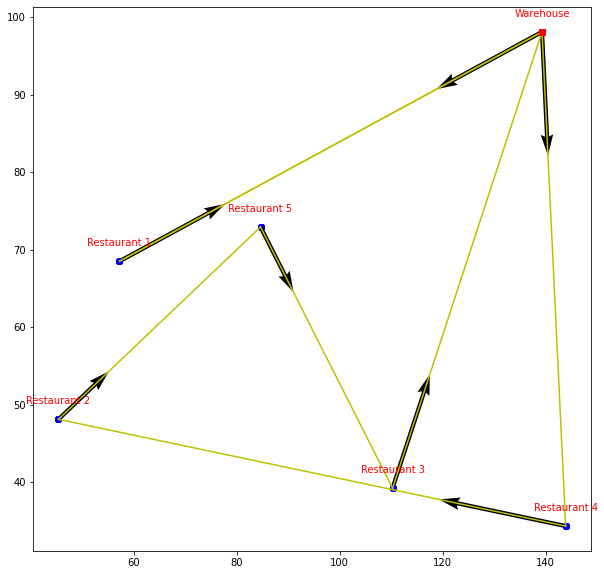

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='y', zorder=1)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')
    ax.quiver(xc[i], yc[i], xc[j]- xc[i], yc[j] - yc[i], angles='xy', scale_units='xy', scale=4)

label = ("Warehouse","Restaurant 1","Restaurant 2","Restaurant 3","Restaurant 4","Restaurant 5")

for x,y,l in zip(xc,yc,label):
    
    plt.annotate(l, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center',
                 c="r") # horizontal alignment can be left, right or center

plt.show()

<font color='darkcyan'>**II. Minimize total travelling distances LP**</font>

In [120]:
#Minimize Travelling Distance 
vr1 = Model("vehicle_routing")

# Create variables
x1 = vr1.addVars(A, vtype=GRB.BINARY, name = "location")

u1 = vr1.addVars(V,vtype=GRB.CONTINUOUS, name = "loc_count") #location of restaurants

# Set objective - minimize travelling costs
vr1.setObjective( quicksum(d[i,j]*x1[i,j] for (i,j) in A), GRB.MINIMIZE)

# Assignment constraints:
vr1.addConstrs((quicksum(x1[i,j] for j in V if j!=i) == 1 for i in N)) # outflow nodes
vr1.addConstrs((quicksum(x1[i,j] for i in V if i!=j) == 1 for j in N)) # inflow nodes

# Location count (nodes) constraints:
vr1.addConstrs(( x1[i, j] == 1) >> (u1[i]+ F[j] == u1[j])  for i, j in A if i != 0 and j != 0)

# Precedence constraints
vr1.addConstrs(u1[i] >= F[i] for i in N )

# Truck delivery capacity constraint:
vr1.addConstrs(u1[i] <= Q for i in N)

# Solving the model
vr1.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 36 columns and 60 nonzeros
Model fingerprint: 0x062acaa1
Model has 20 general constraints
Variable types: 6 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve added 21 rows and 0 columns
Presolve removed 0 rows and 10 columns
Presolve time: 0.00s
Presolved: 41 rows, 26 columns, 181 nonzeros
Variable types: 10 continuous, 16 integer (16 binary)

Root relaxation: objective 3.587014e+02, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  358.70144    0    8          -  358.70144      -     -    0s
H    0     0                     596.71551

In [98]:
print('Minimized delivery distance: %g' % vr1.objVal)

Minimized delivery distance: 444.509


In [121]:
active_arcs1 = [a for a in A if x1[a].x > 0.99]
active_arcs1

[(0, 2), (0, 5), (1, 0), (2, 1), (3, 4), (4, 0), (5, 3)]

In [31]:
#print loc count
for v in u1: 
    print(u1[v].VarName, u1[v].x)

loc_count[0] 0.0
loc_count[1] 885.0
loc_count[2] 790.0
loc_count[3] 751.0
loc_count[4] 360.0
loc_count[5] 885.0


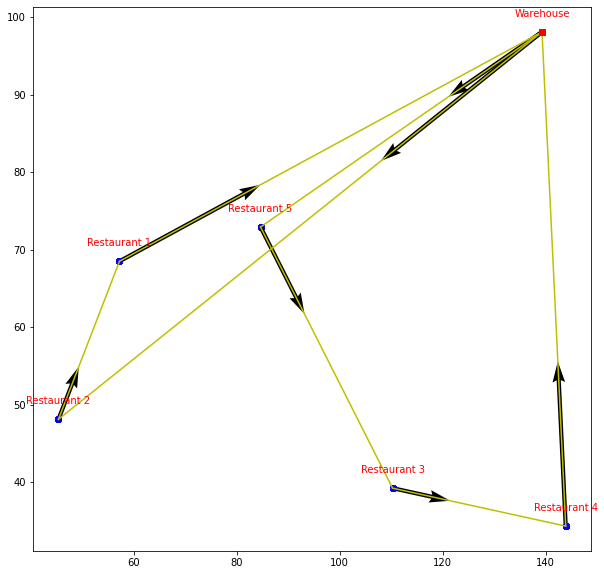

In [122]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, j in active_arcs1:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='y', zorder=1)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')
    ax.quiver(xc[i], yc[i], xc[j]- xc[i], yc[j] - yc[i], angles='xy', scale_units='xy', scale=3)

label = ("Warehouse","Restaurant 1","Restaurant 2","Restaurant 3","Restaurant 4","Restaurant 5")

for x,y,l in zip(xc,yc,label):
    
    plt.annotate(l, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center',
                 c="r") # horizontal alignment can be left, right or center

plt.show()

#### SCENARIO 2: ONE TRUCK WITH UNLIMITED CAPACITY + SUBTOUR CONSTRAINTS (CONVENTIONAL TSP MODEL)

**Assumptions**:
*  Truck has Unlimited Holding Capacity
*  Subtour constrains - aka does not allow the truck to go back to warehouse
*  Only need to go to each restaurant once to deliver

<font color='darkcyan'>**I. Minimize total travelling costs LP**</font>

In [108]:
#########Model Set-up############
#Minimize Travelling Cost
vr2 = Model("vehicle_routing")

# Create variables
x2 = vr2.addVars(A, vtype=GRB.BINARY, name = "location")

u2 = vr2.addVars(V,vtype=GRB.CONTINUOUS, name = "loc_count") #location of restaurants

# Set objective - minimize travelling costs
vr2.setObjective( quicksum(c[i,j]*x2[i,j] for (i,j) in A), GRB.MINIMIZE)

# Assignment constraints:
vr2.addConstrs((quicksum(x2[i,j] for j in V if j!=i) == 1 for i in N)) # outflow nodes
vr2.addConstrs((quicksum(x2[i,j] for i in V if i!=j) == 1 for j in N)) # inflow nodes

# Subtour-breaking constraints:
M = 10000
vr2.addConstrs(( u2[i] + 1 - u2[j] <= M*(1 - x2[i,j])  for i in V for j in V[1:] if i != j))

# Precedence constraints
precedent_pair = tuplelist()
for i in V:
    for j in V:
        if j!=i:
            if i==0:
                precedent_pair.append((i,j))
vr2.addConstrs( (u2[i] <= u2[j] for (i,j) in precedent_pair)  )

# Solving the model
vr2.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40 rows, 36 columns and 135 nonzeros
Model fingerprint: 0x6fe037b7
Variable types: 6 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 598.0000000
Presolve removed 10 rows and 11 columns
Presolve time: 0.00s
Presolved: 30 rows, 25 columns, 100 nonzeros
Variable types: 5 continuous, 20 integer (20 binary)

Root relaxation: objective 1.270010e+02, 13 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  127.00100    0    9  598.00000  127.00100  78.8%     -    0s
H    0     0                     302.0000000  127.00100  57.9% 

In [109]:
print('Minimized delivery cost: %g' % vr2.objVal)

Minimized delivery cost: 201


In [110]:
active_arcs3 = [a for a in A if x2[a].x > 0.99]
active_arcs3

[(0, 3), (1, 0), (2, 4), (3, 5), (4, 1), (5, 2)]

In [35]:
#  Obtain the permutation as a representation of the tour
s_edge = []
for v in x2:    
    if x2[v].x > 0.001:
        #append the edge to the resulting list of edges
        s_edge.append(v)

print(s_edge)

[(0, 3), (1, 0), (2, 4), (3, 5), (4, 1), (5, 2)]


In [36]:
permu = np.ones(len(V))
predecessor = 0
for i in V:
    for s in s_edge:
        if s[0] == predecessor:
            permu[i] = s[0]
            predecessor = s[1]
            break    
    
print(permu)

[0. 3. 5. 2. 4. 1.]


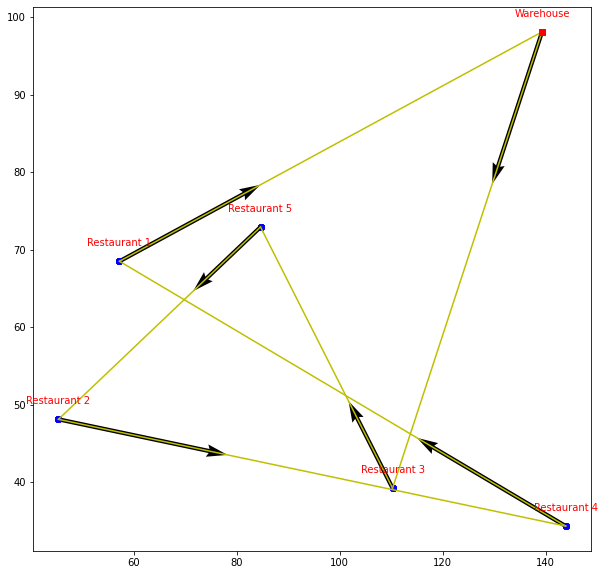

In [111]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, j in active_arcs3:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='y', zorder=1)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')
    ax.quiver(xc[i], yc[i], xc[j]- xc[i], yc[j] - yc[i], angles='xy', scale_units='xy', scale=3)

label = ("Warehouse","Restaurant 1","Restaurant 2","Restaurant 3","Restaurant 4","Restaurant 5")

for x,y,l in zip(xc,yc,label):
    
    plt.annotate(l, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center',
                 c="r") # horizontal alignment can be left, right or center

plt.show()


<font color='darkcyan'>**II. Minimize total travelling distances LP**</font>

In [112]:
#Minimize Travelling Distance 
vr4 = Model("vehicle_routing")

# Create variables
x4 = vr4.addVars(A, vtype=GRB.BINARY, name = "location")

u4 = vr4.addVars(V,vtype=GRB.CONTINUOUS, name = "loc_count") #location of restaurants

# Set objective - minimize travelling costs
vr4.setObjective( quicksum(d[i,j]*x4[i,j] for (i,j) in A), GRB.MINIMIZE)

# Assignment constraints:
vr4.addConstrs((quicksum(x4[i,j] for j in V if j!=i) == 1 for i in N)) # outflow nodes
vr4.addConstrs((quicksum(x4[i,j] for i in V if i!=j) == 1 for j in N)) # inflow nodes

# Subtour-breaking constraints:
M = 10000
vr4.addConstrs(( u4[i] + 1 - u4[j] <= M*(1 - x4[i,j])  for i in V for j in V[1:] if i != j))

# Precedence constraints
precedent_pair = tuplelist()
for i in V:
    for j in V:
        if j!=i:
            if i==0:
                precedent_pair.append((i,j))
vr4.addConstrs( (u4[i] <= u4[j] for (i,j) in precedent_pair)  )

# Solving the model
vr4.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 40 rows, 36 columns and 135 nonzeros
Model fingerprint: 0x4eb09cf0
Variable types: 6 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 766.7625441
Presolve removed 10 rows and 11 columns
Presolve time: 0.00s
Presolved: 30 rows, 25 columns, 100 nonzeros
Variable types: 5 continuous, 20 integer (20 binary)

Root relaxation: objective 1.657464e+02, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  165.74644    0    9  766.76254  165.74644  78.4%     -    0s
H    0     0                     380.9936306  165.74644  56.5% 

In [114]:
print('Minimized delivery distances: %g' % vr4.objVal)
active_arcs4 = [a for a in A if x4[a].x > 0.99]
active_arcs4

Minimized delivery distances: 274.931


[(0, 5), (1, 2), (2, 3), (3, 4), (4, 0), (5, 1)]

In [113]:
#  Obtain the permutation as a representation of the tour
s_edge = []
for v in x4:    
    if x4[v].x > 0.001:
        #append the edge to the resulting list of edges
        s_edge.append(v)

print(s_edge,"\n")

permu = np.ones(len(V))
predecessor = 0
for i in V:
    for s in s_edge:
        if s[0] == predecessor:
            permu[i] = s[0]
            predecessor = s[1]
            break    
    
print(permu)

[(0, 5), (1, 2), (2, 3), (3, 4), (4, 0), (5, 1)] 

[0. 5. 1. 2. 3. 4.]


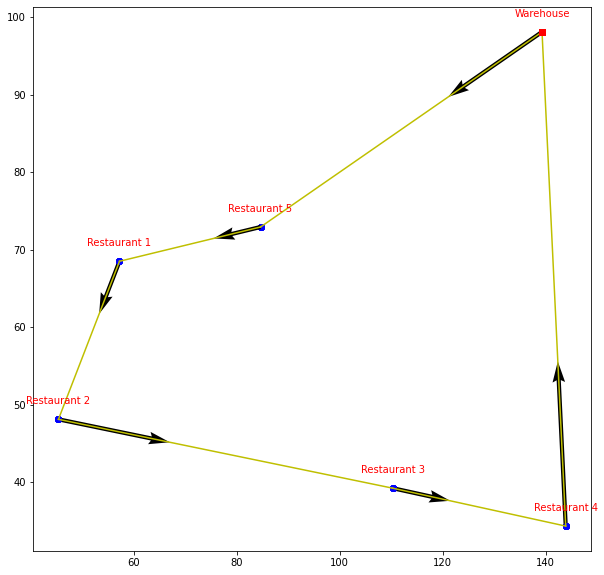

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, j in active_arcs4:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='y', zorder=1)
    plt.plot(xc[0], yc[0], c='r', marker='s')
    plt.scatter(xc[1:], yc[1:], c='b')
    ax.quiver(xc[i], yc[i], xc[j]- xc[i], yc[j] - yc[i], angles='xy', scale_units='xy', scale=3)

label = ("Warehouse","Restaurant 1","Restaurant 2","Restaurant 3","Restaurant 4","Restaurant 5")

for x,y,l in zip(xc,yc,label):
    
    plt.annotate(l, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center',
                 c="r") # horizontal alignment can be left, right or center

plt.show()